In [1]:
%matplotlib inline

import matplotlib
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import datetime
from statsmodels.tsa.stattools import grangercausalitytests
from scipy.stats import multivariate_normal
import os
from dirichlet import simplex
from plot_utils import errorBars

os.chdir('/Users/sbittner/Documents/efn/');

"""
exp_fam = 'dirichlet';
K_eta = 100;
M = 1000;
D_Z = 25;
flow_id = 'planar30';
L = 8;
upl = 100;
lr_order = -3;
"""
exp_fam = 'normal';
K_eta = 100;
M = 1000;
D_Z = 40;
flow_id = 'linear1';
L = 8;
upl = 160;
lr_order = -3;

basedir = '/Users/sbittner/Documents/efn/results/MK/tb/';

#modelstr = 'EFN_%s_K=%d_D=%d_%s_L=%d_upl=%d_RS=0/' % \
#          (constraint_id, K_eta, D_Z, flow_id, L, upl);
#modelstr = 'EFN_%s_K=%d_D=%d_%s_L=%d_upl=%d_lr=%d/' % \
#          (constraint_id, K_eta, D_Z, flow_id, L, upl, lr_order);
rs = 1;  
modelstr = 'EFN_%s_D=%d_K=%d_M=%d_%s_L=%d_upl=%d_RS=%d/' % \
                    (exp_fam, D_Z, K_eta, M, flow_id, L, upl, rs);

savedir = basedir + modelstr;
fname = savedir + 'results.npz';
X = np.load(fname);
nits = X['it'];

train_R2s = X['train_R2s'];
train_KLs = X['train_KLs'];
test_R2s = X['test_R2s'];
test_KLs = X['test_KLs'];
check_diagnostic_rate = 200;
its = np.arange(nits);
fontsize = 20;


/Users/sbittner/Library/Python/3.6/lib/python/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


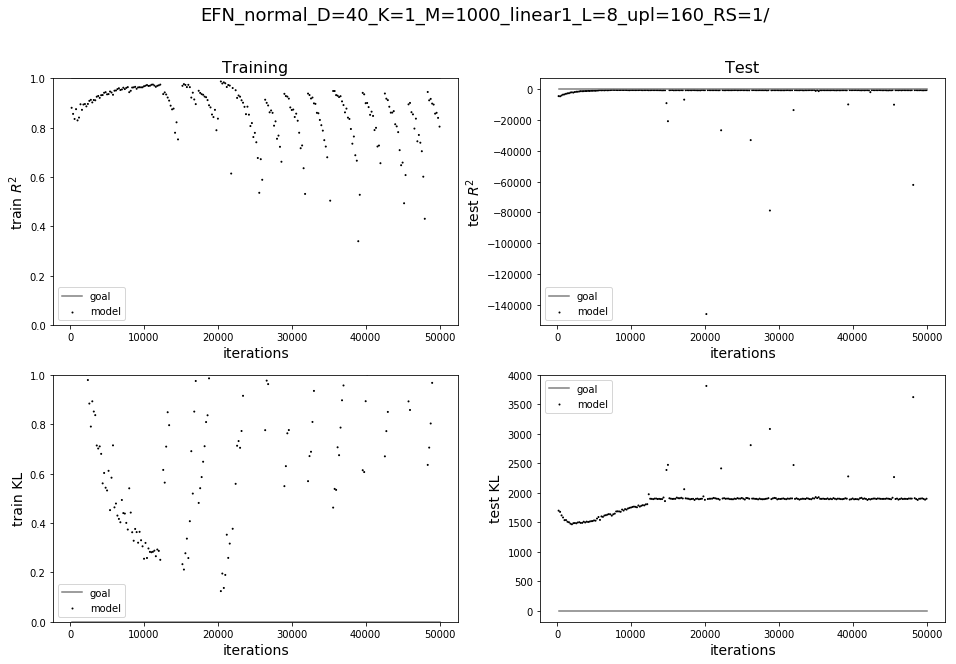

In [2]:
fontsize = 14;
N = train_R2s.shape[0];
K_eta = train_R2s.shape[1];
its = check_diagnostic_rate*np.arange(1,N+1, dtype=float);
its = np.tile(np.expand_dims(its, 1), [1,K_eta]);
its_vec = np.reshape(its, (N*K_eta,));
train_R2s_vec = np.reshape(train_R2s, (N*K_eta,))
test_R2s_vec = np.reshape(test_R2s, (N*K_eta,))
train_KLs_vec = np.reshape(train_KLs, (N*K_eta,))
test_KLs_vec = np.reshape(test_KLs, (N*K_eta,))
size = np.ones((N*K_eta,));
fig = plt.figure(figsize=(16,10));
    
fig.add_subplot(2,2,1);
plt.plot([np.min(its), np.max(its)], [1,1], 'tab:gray');
plt.scatter(its_vec, train_R2s_vec,size,c='k');
plt.legend(['goal', 'model']);
plt.xlabel('iterations', fontsize=fontsize);
plt.xlabel('iterations', fontsize=fontsize);
plt.ylabel('train $R^2$', fontsize=fontsize)
plt.title('Training', fontsize=fontsize+2);
plt.ylim([0,1]);
plt.suptitle(modelstr, fontsize=fontsize+4)

fig.add_subplot(2,2,2);
plt.plot([np.min(its), np.max(its)], [1,1], 'tab:gray');
plt.scatter(its_vec, test_R2s_vec,size,c='k');
plt.legend(['goal', 'model']);
plt.xlabel('iterations', fontsize=fontsize);
plt.xlabel('iterations', fontsize=fontsize);
plt.ylabel('test $R^2$', fontsize=fontsize)
plt.title('Test', fontsize=fontsize+2);
#plt.ylim([-1000,1]);
    
fig.add_subplot(2,2,3);
plt.plot([np.min(its), np.max(its)], [0,0], 'tab:gray');
plt.scatter(its_vec, train_KLs_vec,size,c='k');
plt.legend(['goal', 'model']);
plt.xlabel('iterations', fontsize=fontsize);
plt.ylabel('train KL', fontsize=fontsize)
plt.ylim([0,1]);

fig.add_subplot(2,2,4);
plt.plot([np.min(its), np.max(its)], [0,0], 'tab:gray');
plt.scatter(its_vec, test_KLs_vec,size,c='k');
plt.legend(['goal', 'model']);
plt.xlabel('iterations', fontsize=fontsize);
plt.ylabel('test KL', fontsize=fontsize)
#plt.ylim([0,1500]);


plt.show();


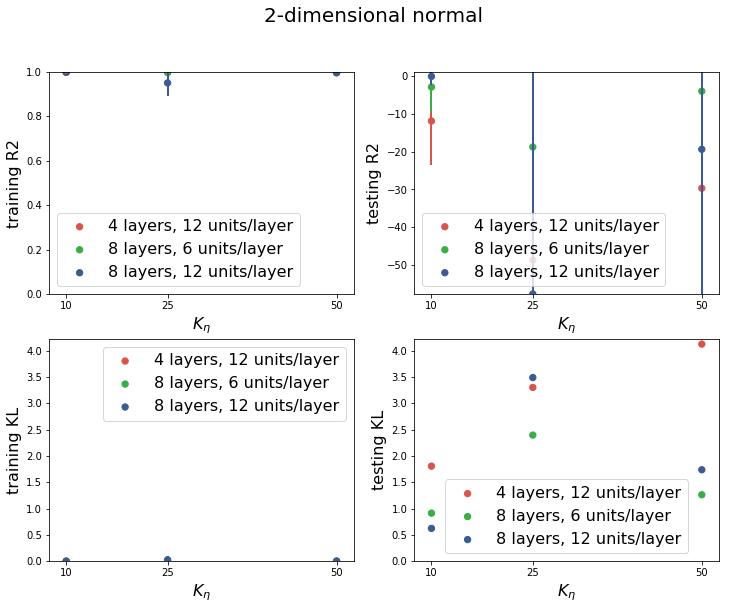

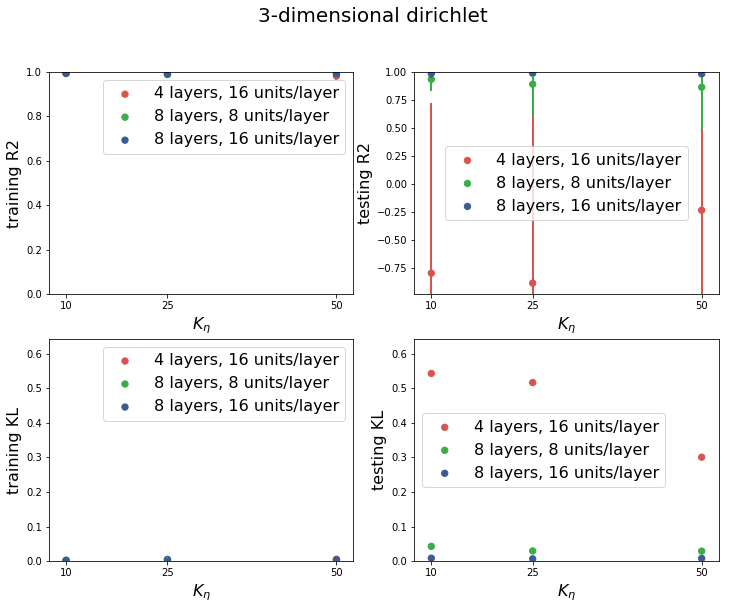

In [141]:
fontsize = 16;
exp_fams = ['normal', 'dirichlet'];
Ds = [2, 3];
flow_ids = ['linear1', 'planar10'];
num_exp_fams = len(exp_fams);

Ks = [10, 25, 50];
num_Ks = len(Ks);

Ls = [4, 8, 8];
upls_normal = [12, 6, 12];
upls_dirichlet = [16, 8, 16];
num_HPs = len(Ls);

train_R2s_mean = np.zeros((num_Ks, num_HPs));
test_R2s_mean = np.zeros((num_Ks, num_HPs));
train_KLs_mean = np.zeros((num_Ks, num_HPs));
test_KLs_mean = np.zeros((num_Ks, num_HPs));

train_R2s_std = np.zeros((num_Ks, num_HPs));
test_R2s_std = np.zeros((num_Ks, num_HPs));
train_KLs_std = np.zeros((num_Ks, num_HPs));
test_KLs_std = np.zeros((num_Ks, num_HPs));

basedir = '/Users/sbittner/Documents/efn/results/lowD_hpsearch/';
x = np.array(Ks);
for ii in range(num_exp_fams):
    exp_fam = exp_fams[ii];
    D = Ds[ii];
    flow_id = flow_ids[ii];
    legendstrs = [];
    for i in range(num_Ks):
        K_eta = Ks[i];
        for j in range(num_HPs):
            L = Ls[j];
            if (exp_fam == 'normal'):
                upl = upls_normal[j];
            elif (exp_fam == 'dirichlet'):
                upl = upls_dirichlet[j];
            if (i==0):
                legendstrs.append('%d layers, %d units/layer' % (L, upl));
            modelstr = 'EFN_%s_K=%d_D=%d_%s_L=%d_upl=%d_RS=0/' % \
                        (exp_fam, K_eta, D, flow_id, L, upl);
            fname = basedir + modelstr + 'results.npz';
            X = np.load(fname);
            train_R2s_ij = X['train_R2s'];
            train_KLs_ij = X['train_KLs'];
            test_R2s_ij = X['test_R2s'];
            test_KLs_ij = X['test_KLs'];
            
            train_R2s_mean[i,j] = np.mean(train_R2s_ij[-1,:]);
            train_R2s_std[i,j] = np.std(train_R2s_ij[-1,:]);
            train_KLs_mean[i,j] = np.mean(train_KLs_ij[-1,:]);
            train_KLs_std[i,j] = np.std(train_KLs_ij[-1,:]);
            
            test_R2s_mean[i,j] = np.mean(test_R2s_ij[-1,:]);
            test_R2s_std[i,j] = np.std(test_R2s_ij[-1,:]);
            test_KLs_mean[i,j] = np.mean(test_KLs_ij[-1,:]);
            test_KLs_std[i,j] = np.std(test_KLs_ij[-1,:]);
            
    KLmax = max(np.max(train_KLs_mean), np.max(test_KLs_mean));
    KLbuf = .1;
    R2min = min(np.min(train_R2s_mean), np.min(test_R2s_mean));
    R2buf = .1;
    
    fig = plt.figure(figsize=(12,9));
    ax = fig.add_subplot(2,2,1);
    errorBars(x, train_R2s_mean, train_R2s_std, legendstrs);
    ax.set_xticks(Ks);
    plt.xlabel('$K_\eta$', fontsize=fontsize);
    plt.ylabel('training R2', fontsize=fontsize);
    plt.ylim([0, 1]);

    ax = fig.add_subplot(2,2,2);
    errorBars(x, test_R2s_mean, test_R2s_std, legendstrs);
    ax.set_xticks(Ks);
    plt.xlabel('$K_\eta$', fontsize=fontsize);
    plt.ylabel('testing R2', fontsize=fontsize);
    plt.ylim([R2min-R2buf, 1]);
    plt.suptitle('%d-dimensional %s' % (D, exp_fam), fontsize=fontsize+4);
    
    ax = fig.add_subplot(2,2,3);
    errorBars(x, train_KLs_mean, train_KLs_std, legendstrs);
    ax.set_xticks(Ks);
    plt.xlabel('$K_\eta$', fontsize=fontsize);
    plt.ylabel('training KL', fontsize=fontsize);
    plt.ylim([0, KLmax+KLbuf]);

    ax = fig.add_subplot(2,2,4);
    errorBars(x, test_KLs_mean, train_KLs_std, legendstrs);
    ax.set_xticks(Ks);
    plt.xlabel('$K_\eta$', fontsize=fontsize);
    plt.ylabel('testing KL', fontsize=fontsize);
    plt.ylim([0, KLmax+KLbuf]);
    plt.suptitle('%d-dimensional %s' % (D, exp_fam), fontsize=fontsize+4);
    


In [3]:
print(train_R2s)

[[ -9.19502879]
 [ -5.83922368]
 [ -6.76310352]
 [ -8.62397411]
 [ -5.01704953]
 [ -6.23714794]
 [ -9.69837308]
 [ -9.82553988]
 [ -8.12836627]
 [ -8.69979627]
 [ -6.54596077]
 [-10.58775684]
 [ -9.21282049]
 [-10.09743052]
 [ -9.69025118]
 [-10.57286791]
 [         nan]
 [         nan]
 [         nan]
 [         nan]
 [         nan]
 [         nan]
 [         nan]
 [         nan]
 [         nan]
 [         nan]
 [         nan]
 [         nan]
 [         nan]
 [         nan]
 [         nan]
 [         nan]
 [         nan]
 [         nan]
 [         nan]
 [         nan]
 [         nan]
 [         nan]
 [         nan]
 [         nan]
 [         nan]
 [         nan]
 [         nan]
 [         nan]
 [         nan]
 [         nan]
 [         nan]
 [         nan]
 [         nan]
 [         nan]
 [         nan]
 [         nan]
 [         nan]
 [         nan]
 [         nan]
 [         nan]
 [         nan]
 [         nan]
 [         nan]
 [         nan]
 [         nan]
 [         nan]
 [      